In [27]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts", "lib"))



import numpy as np
import pandas as pd
from cov_functions import *
from clustering_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import pingouin as pg
from statsmodels.stats.multitest import multipletests
#import itertools
warnings.filterwarnings('ignore')
#import bambi as bmb
#import arviz as az
#import json
#import pickle
#import tslearn as tsl

# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
#sys.path.insert(1, os.path.join(root_dir, "covid-fear", "scripts", "lib", "hoeffding"))

##### VERY IMPORTANT ####
df = df.rename(columns={
                        "cases14_std_unsmooth": "cases", 
                        "deaths14_std_unsmooth": "deaths", 
                        "q7_period_rel_danger": "perceived_danger", 
                        "q7_period_rel_safety": "perceived_safety", 
                        "q7_worry_econ_impact": "econ_worry", 
                         "worryhealth": "health_worry", 
                         "prob_est": "ProbEst", 
                         "covid_worry": "CovidWorry", 
                         "q7_avoid": "Avoid", 
                         "q6_apply_soc_dist": "SocialDist" })

df["state_severity"] = df["deaths7_norm"]
df["Session"] = df["session"] +1





/data/drive/postdoc/Project4_covid


In [28]:
# Create column with appropriate dates

df["date"] = pd.to_datetime( df["submitdate"]).dt.strftime("%B '%y")
months = df.groupby(by="Session")["date"].apply(lambda x: np.array(x.reset_index().iloc[0,1])).reset_index()
months["session"] = months["Session"]-1


## Figure 1: overall plot 

In [29]:
# normalize within participant
#df["econ_worry_norm"]= df.groupby(by="PROLIFICID")["econ_worry"].apply(normalize)
#sdf["health_worry_norm"]= df.groupby(by="PROLIFICID")["health_worry"].apply(normalize)
columns = ["cases","perceived_danger","deaths", "Avoid", "CovidWorry","ProbEst" ]#,  "econ_worry", "health_worry"]
tdf = df.loc[:,["Session", "PROLIFICID"]+columns]
for c in columns: 
    tdf[c] = tdf.groupby(by="PROLIFICID")[c].apply(normalize)
tdf = tdf.melt(id_vars = ["Session", "PROLIFICID"], value_vars=columns)

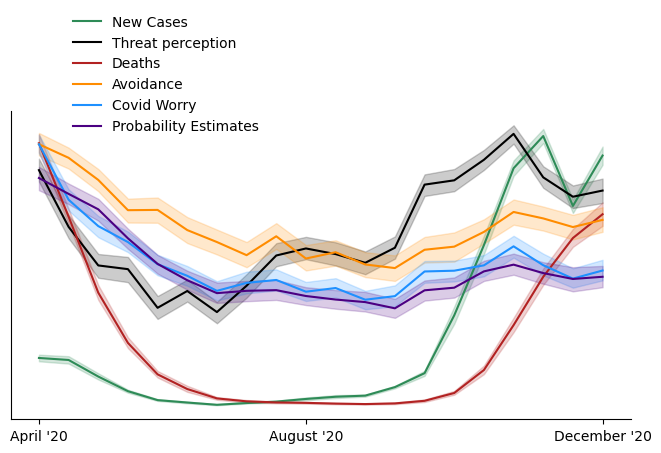

In [30]:

#scolumns = ["econ_worry_norm", "health_worry_norm"]

# normalize within participant


f,ax = plt.subplots(1,1, figsize=(8,4))
ax = sns.lineplot(data=tdf, x="Session", y="value", hue="variable", ax=ax, legend=True, palette=["seagreen", "black", "firebrick", "darkorange", "dodgerblue", "indigo"])
#ax.legend
ax.set_ylabel("")
ax.set_yticklabels("")
ax.get_legend().set_title("")
sessions = np.array([1,10,20])-1
ax.set_xticks(months["Session"].iloc[sessions])
ax.set_xticklabels(months["date"].iloc[sessions])
ax.set_xlabel("")
plt.tick_params(left = False)
#sns.move_legend(ax, "upper center",  ncol=2, bbox_to_anchor=(0.42, 1.12)) #bbox_to_anchor=(1.3, 1),
sns.move_legend(ax, "right",  ncol=1, bbox_to_anchor=(0.42, 1.12)) #bbox_to_anchor=(1.3, 1),
sns.despine(fig=f, ax=ax, top=True)

new_labels = ["New Cases", "Threat perception","Deaths", "Avoidance", "Covid Worry",  "Probability Estimates"]

ax.get_legend().get_frame().set_linewidth(0.0)

for t, l  in zip(ax.get_legend().texts, new_labels):
    t.set_text(l)

plt.savefig(os.path.join(root_dir, 'output', 'research_report', 'fig1a_raw.pdf'), dpi=300, quality=80, optimize=True, progressive=True)  





## Figure 2


ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc    np2      eps
-----------  ------  -----  -----  ------  -----  -------  -----  -------
cl           11.063      1    298  11.063  6.840    0.009  0.022  nan
variable      0.012      2    596   0.006  0.015    0.985  0.000    0.835
Interaction   3.799      2    596   1.899  4.714    0.009  0.016  nan

     T      dof  alternative      p-val  CI95%            cohen-d     BF10    power  contrast                     p-holm
------  -------  -------------  -------  -------------  ---------  -------  -------  -------------------------  --------
-1.407  171.000  two-sided        0.161  [-0.28  0.05]      0.126    0.224    0.374  TF3>TF2, cluster 0            0.806
-0.165  171.000  two-sided        0.869  [-0.12  0.1 ]      0.010    0.086    0.052  TF3>TF1, cluster 0            1.000
-1.526  171.000  two-sided        0.129  [-0.24  0.03]      0.117    0.265    0.331  TF1>TF2, cluster 0            0.774
 1.872  127.000 

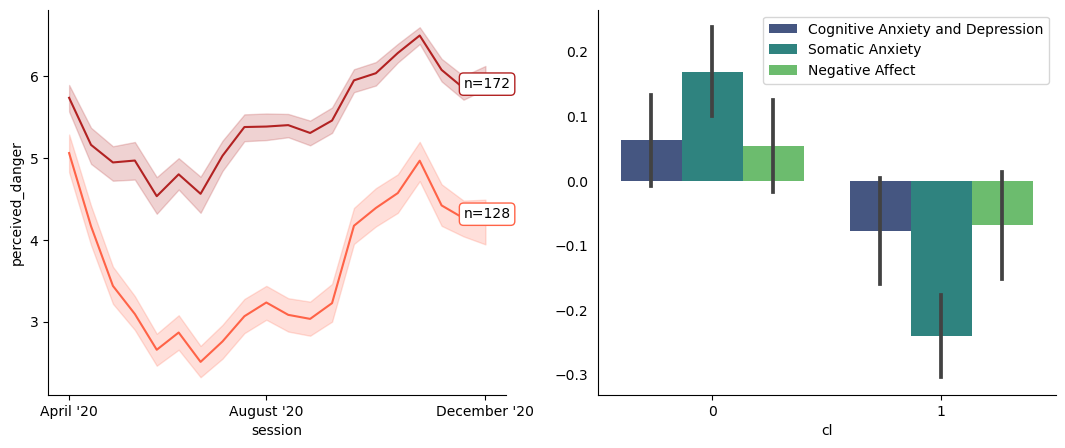

In [33]:
trait_factor_names = ["TF1_CognAnxDepr", "TF2_PhysiolAnx", "TF3_NegativeAffect"]


for depvar in ["perceived_danger"]:#, "CovidWorry", "ProbEst"]:
    tdf = df.loc[:,[depvar]+["session", "PROLIFICID"]]
    tdf = tdf.pivot(index='PROLIFICID', columns='session', values=depvar).add_prefix('sess')

    # Vrey important, otherwise clustering doesn't work! 
    tdf = tdf.interpolate(method='linear', axis=1)

    # turn to timeseries data type
    ts = to_time_series(tdf)

    tdf, m = estimate_clusters(ts,tdf, n_clusters=2, metric="euclidean")

    # get information from the model
    ts = to_time_series(tdf.drop(columns=["cl", "id"]))
    cl_ids = m.predict(ts) 
    clusters = np.transpose(np.squeeze(m.cluster_centers_))
    (unique, counts) = np.unique(cl_ids, return_counts=True)

    # where will labels be shown 
    y = clusters[18,:]
    me=tdf[["sess18", "cl"]].groupby("cl").mean()
    yme=np.array(me["sess18"])

    # turn back to long format
    tdf2 = tdf.melt(id_vars=["id", "cl"], value_vars=["sess"+str(x) for x in range(20)]).set_index("id")

    pal = []
    palc= []
    n_clusters = 2
    for nc in range(n_clusters): 
        col = sns.cubehelix_palette(start=nc, rot=-.1, n_colors=3)
        pal.append(col)
        palc.append(col[1])

    # plot 

    fi, ax = plt.subplots(1,2,figsize=(13,5) ) 
    pal=sns.color_palette("rocket_r", n_clusters)
    pal=["firebrick", "tomato"]
    f = sns.lineplot(data=tdf2, x="session", y="value", hue="cl", palette=pal, ax=ax[0], legend=False)
    f.set_xticklabels([str(i) for i in range(20)])
    f.set_ylabel(depvar) 
    sessions = np.array([1,10,20])-1
    f.set_xticks(months["session"].iloc[sessions])
    f.set_xticklabels(months["date"].iloc[sessions])
    plt.tick_params(left = False)
    sns.despine(fig=fi, ax=f, top=True)

    #fig, ax = plt.subplots(1,len(huevar), figsize=(len(huevar)*4, 5))
    #for f_idx, hv in enumerate(huevar):

        # add anxiety to the dataset
    stdf = tdf2.join(df.loc[:,["PROLIFICID"]+trait_factor_names].groupby("PROLIFICID").mean())

        # Set your custom color palette
    #    pal=sns.color_palette("rocket_r", n_clusters)
        
        #get mean anxiety per bin
    anx_cluster = stdf.loc[:,["cl"]+trait_factor_names].groupby(["cl"]).mean()
    #    plt.ylabel(dep_var)
    x = 18
    for i,v,c,y in zip(np.array(anx_cluster.index),unique, counts,yme):
        #f.annotate("n="+str(c)+" cluster="+str(v), (x,y),   bbox=dict(boxstyle="round", fc="w", edgecolor=pal[i]))
        f.annotate("n="+str(c), (x,y),   bbox=dict(boxstyle="round", fc="w", edgecolor=pal[i]))


    ### show second plot
    stdf = tdf.loc[:,["id", "cl"]].join(df.loc[:,["PROLIFICID"]+trait_factor_names].groupby("PROLIFICID").mean())
    #for t in trait_factor_names:
    #    stdf[t] =  stdf[t] - stdf[t].min() 
    stdf = stdf.melt(id_vars=["id", "cl"], value_vars=trait_factor_names).set_index("id")


    ax[1]=sns.barplot(data=stdf, x="cl", y="value", hue="variable", errorbar="se", ax=ax[1],  palette=sns.color_palette("viridis", 3))
    ax[1].set_ylabel("") 
    ax[1].get_legend().set_title("")
    new_labels =["Cognitive Anxiety and Depression", "Somatic Anxiety", "Negative Affect"]
    for t, l  in zip(ax[1].get_legend().texts, new_labels):
        t.set_text(l)
    plt.tick_params(left = False)
    sns.despine(fig=fi, ax=ax[1], top=True)
    #for b in axx.bar:
    #    print(b)
    plt.savefig(os.path.join(root_dir, 'output', 'research_report', 'fig1b_raw.pdf'), dpi=300, quality=80, optimize=True, progressive=True)  


    aov = pg.mixed_anova(data=stdf, dv='value', between='cl', within='variable',
                        subject='id', correction=False, effsize="np2")
    pg.print_table(aov)
    resdf = pd.DataFrame()
    for c in [0,1]:
        tdf = stdf.loc[stdf["cl"]==c,:]
        res = pg.ttest( x=tdf.loc[tdf["variable"]=="TF3_NegativeAffect","value"],
                        y=tdf.loc[tdf["variable"]=="TF2_PhysiolAnx","value"],
                        paired=True)
        res["contrast"] = "TF3>TF2, cluster "+str(c)
        resdf = pd.concat([resdf, res], axis=0)

        res = pg.ttest( x=tdf.loc[tdf["variable"]=="TF3_NegativeAffect","value"],
                        y=tdf.loc[tdf["variable"]=="TF1_CognAnxDepr","value"],
                        paired=True)
        res["contrast"] = "TF3>TF1, cluster "+str(c)
        resdf = pd.concat([resdf, res], axis=0)

        res = pg.ttest( x=tdf.loc[tdf["variable"]=="TF1_CognAnxDepr","value"],
                        y=tdf.loc[tdf["variable"]=="TF2_PhysiolAnx","value"],
                        paired=True)
        res["contrast"] = "TF1>TF2, cluster "+str(c)
        resdf = pd.concat([resdf, res], axis=0)



    for t in trait_factor_names:
        tdf = stdf.loc[stdf["variable"]==t,:]
        res = pg.ttest( x=tdf.loc[tdf["cl"]==0,"value"],
                        y=tdf.loc[tdf["cl"]==1,"value"],
                        paired=False)
        res["contrast"] = "cl0>cl1"+t
        resdf = pd.concat([resdf, res], axis=0)

    resdf["p-holm"] = np.round(multipletests(resdf["p-val"], alpha=0.05, method="holm")[1],4)
    pg.print_table(resdf)


